<a href="https://colab.research.google.com/github/JonathanKulpa/Motion-Artifact-Signal-Generation-Toolkit/blob/Branch1/RNN_Train_and_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN Training and Simulation**

This python notebook allows you to train a Recurrent Neural Network (RNN) using a sample motion artifact signal, and output a simulated motion artifact signal using the model.

If you plan on training the model and simulating a motion artifact signal from the model, run all the cells.

If you only plan on training the model, run the cells up until the beginning of Part 2.

If you plan on simulating a motion artifact signal using a model that was trained previously, run the following  two cells for loading the required libraries and defining functions, and then continue running from Part 2.

To ensure the model can be trained quickly, set the python notebook to run on a GPU using the setting below in Google Colab.

Edit > Notebook Settings > GPU

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, mean
from scipy.signal import butter, freqz
from scipy.fftpack import fft
import os
from tensorflow import keras
import datetime
import scipy.io.wavfile
from scipy.interpolate import splrep, splev
import io
from google.colab import files
from keras import regularizers
from zipfile import ZipFile
from os.path import basename

## RNN Functions

**split_input_target:** Takes a window of data and converts it into an input and a target.

**build_model:** Provides the RNN model that will be trained (3 GRU layers)

**loss:** Defines the loss function.

In [ ]:
def split_input_target(chunk):
  input = chunk[:-1]
  target = chunk[1:]
  return input, target

def build_model(numUniqueCharacters, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
        tf.keras.layers.Embedding(numUniqueCharacters, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',stateful=True), #,recurrent_regularizer = keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',stateful=True), #,recurrent_regularizer = keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',stateful=True), #,recurrent_regularizer = keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
  tf.keras.layers.Dense(numUniqueCharacters)
])
  return model

def loss(labels, logits):
  return keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


**If you are simulating a signal using a previously trained model, skip to Part 2.**

# **Uploading Sample Signal and Preprocessing**

Load sample motion artifact and preprocessing

## Uploading Sample Motion Artifact Data

Choose the sample motion artifact data you would like to use to train the model. File must be in *.csv* format to upload.

There are two options to upload the file:

**Option 1: Upload directly from your PC**

Change the filename in the code to match the sample motion artifact data you would like to use to train the model. Once you run the code cell below, click on "*Choose Files*" and select the .csv file you would like to use.

In the cell below, change "*filename*" accordingly.

In [ ]:
uploaded  = files.upload()
data_save = pd.read_csv(io.BytesIO(uploaded['TrainingSignal8.csv']))

x= data_save[:]
#x = x.dropna()

Saving TrainingSignal8.csv to TrainingSignal8.csv


**Option 2: Upload from files saved on Google Drive**

Firstly, you will need to mount your Google Drive onto this Google Colab session.

This is done in the first code cell below. Upon running this cell you will be asked to sign into your Google account, from there you will need to copy a password and paste it back here in the Google Colab session. You will then be able to load and save files to your Google Drive directly from Google Colab.

In [ ]:
#Run this cell to mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Secondly, change the filename in the code below to match the sample motion artifact signal file you would like to use to train the model. You will also need to ensure the file path matches that of your file from your Google Drive.

If you are using a previously trained model, ensure that the motion artifact signal being uploaded matches the signal that was used to train the model.

In the cell below, change 'YOUR_FILE_NAME' and 'YOUR_FILE_PATH' accordingly.

In [ ]:
#Run this cell to download your specific filename
filename = "YOUR_FILE_NAME"
path = "/content/drive/My Drive/YOUR_FILE_PATH/{}.csv".format(filename)
data_save = pd.read_csv(path)

x= data_save["x"]
x = x.dropna()

## Preprocessing and Plotting

Adjust the sampling frequency by changing ***fs*** to match the sampling frequency of the input signal.

Text(0.5, 1.0, 'Input signal')

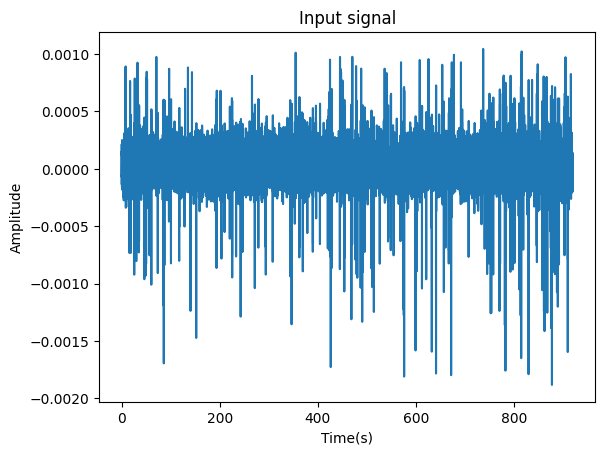

In [ ]:
fs = 128
x = np.asarray(x)

lenx = np.size(x)
t_input = np.linspace(0, lenx/fs, lenx)

# Visualize the generated motion artifact signal over time
plt.plot(t_input, x)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Input signal')

###Lowpass Filter

In [ ]:
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

In [ ]:
# Setting standard filter requirements.

# Specify the order of the lowpass filter
order = 6
# Specify the cutoff frequency for the lowpass filter
cutoff = 20

y = butter_lowpass_filter(x, cutoff, fs, order)

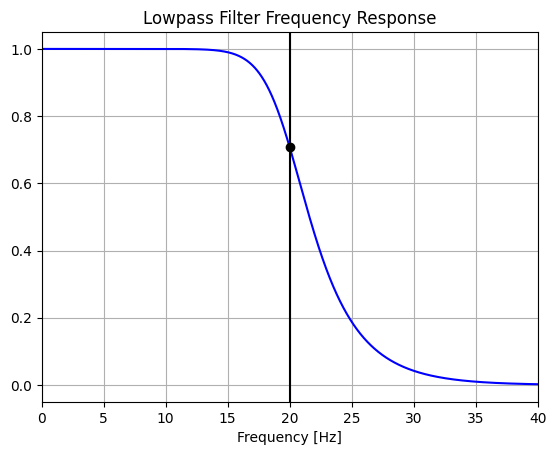

In [ ]:
b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response of the lowpass filter.
w, h = freqz(b, a, worN=8000)
#plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 40)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

###Power Normalization

In [ ]:
signal_power = np.sum(np.square(y))/len(y)
z = y/np.sqrt(signal_power)

###Downsample

Downsample the input signal.

In [ ]:
new_fs = 67
down_factor = fs/new_fs
data = signal.resample(z, np.int(len(z)/down_factor))

<ipython-input-9-4ce3777ef379>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = signal.resample(z, np.int(len(z)/down_factor))


###Plot Preprocessed Signal

In [ ]:
def find_psd(data2, new_fs):
    f, Pxx_den = signal.welch(data2, fs = 67)#, nperseg = len(z)/5)
    return(Pxx_den,f)

pxx, f = find_psd(data, new_fs)

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  warnings.warn('nperseg = {0:d} is greater than input length '


<ipython-input-11-d39dd0fa1dc8>:15: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, 10*np.log10(pxx))


ValueError: ignored

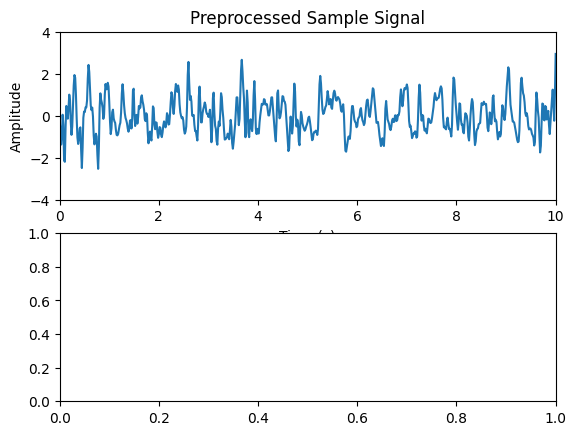

In [ ]:
#Plot preprocessed signal
length_z = np.size(data)
t_processed = np.linspace(0, length_z/new_fs, length_z)
#Preprocessed signal
plt.subplot(2,1,1)
plt.plot(t_processed, data)
plt.xlim([0,10]) #Set time values to zoom on a part of the input signal (seconds)
plt.ylim([-4,4]) #Adjust amplitude values for better viewing
plt.title('Preprocessed Sample Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

#Plot PSD plot of preprocessed signal
plt.subplot(2,1,2)
plt.plot(f, 10*np.log10(pxx))
plt.xlim([0,10]) #Frequency values (Hz) can be adjusted for better viewing
plt.ylim([-35,10]) #Magnitude values (dB) can be adjusted for better viewing
plt.title('Power Spectral Density of Preprocessed Sample Signal')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=0.5)

###Quantize

Quantize the data to 64 values. Output data is labeled *x_q*.

In [ ]:
S_d = 64
x_min = np.min(data)
x_max = np.max(data)
x_q = np.round((data-x_min)/(x_max-x_min)*(S_d-1))
x_q = x_q.astype(int)

# **Part 1: Training**

Train the RNN model using a sample motion artifact signal. The trained RNN model can then be saved.

To ensure the model can be trained quickly, set the python notebook to run on a GPU using the setting below.

Edit > Notebook Settings > GPU

## Build RNN Model

In [ ]:
# =============================================================================
# Window size selection
# =============================================================================

win_length = 500 #window size
win_inc = 25 # window increment

examples_per_epoch = np.size(data)//win_inc
dataset = tf.data.Dataset.from_tensor_slices(x_q)
test = dataset.window(size=win_length, shift=win_inc,stride=1,drop_remainder=True).flat_map(lambda x: x.batch(win_length))
dataset_targets = test.map(split_input_target)

# =============================================================================
# Create training batches
# =============================================================================

# Batch size
BATCH_SIZE = 5
steps_per_epoch = examples_per_epoch//BATCH_SIZE

#shuffle inputs
BUFFER_SIZE = 10000
dataset_train = dataset_targets.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# =============================================================================
# Parameters for RNN Structure
# =============================================================================

# Embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 256

# Define size of dense layer
numUniqueCharacters = int(max(x_q))+1

# =============================================================================
# Build model
# =============================================================================
model = build_model(
  numUniqueCharacters = numUniqueCharacters,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(
    optimizer = optimizer,
    loss = loss,
    )

model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=516)

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) #add .hdf5

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (5, None, 256)            16384     
                                                                 
 gru (GRU)                   (5, None, 256)            394752    
                                                                 
 gru_1 (GRU)                 (5, None, 256)            394752    
                                                                 
 gru_2 (GRU)                 (5, None, 256)            394752    
                                                                 
 dense (Dense)               (5, None, 64)             16448     
                                                                 
Total params: 1,217,088
Trainable params: 1,217,088
Non-trainable params: 0
_________________________________________________________________


## Train RNN Model

Training the classifier will take some time. It may take anywhere from 25 minutes to over 2 hours.

In [ ]:
EPOCHS= 80
history = model.fit(dataset_train.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Epoch 1/80
493/493 [==============================] - 36s 53ms/step - loss: 1.9992
Epoch 2/80
493/493 [==============================] - 34s 68ms/step - loss: 1.3070
Epoch 3/80
493/493 [==============================] - 24s 50ms/step - loss: 1.2480
Epoch 4/80
493/493 [==============================] - 25s 50ms/step - loss: 1.2187
Epoch 5/80
493/493 [==============================] - 27s 54ms/step - loss: 1.1932
Epoch 6/80
493/493 [==============================] - 24s 49ms/step - loss: 1.1683
Epoch 7/80
493/493 [==============================] - 23s 47ms/step - loss: 1.1484
Epoch 8/80
493/493 [==============================] - 23s 47ms/step - loss: 1.1296
Epoch 9/80
493/493 [==============================] - 23s 47ms/step - loss: 1.1114
Epoch 10/80
493/493 [==============================] - 24s 48ms/step - loss: 1.0936
Epoch 11/80
493/493 [==============================] - 24s 48ms/step - loss: 1.0764
Epoch 12/80
493/493 [==============================] - 24s 49ms/step - loss: 1.0586
E

## Save the Model

The two required files to load a model are "saved_model.h5" and the "training_checkpoints" folder containing three files. These files can be saved by running the two code cells below.

Change "***saved_model***" in the code cell below to what you would like the saved model filename to be.

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(numUniqueCharacters, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

model.save('saved_model.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            16384     
                                                                 
 gru_3 (GRU)                 (1, None, 256)            394752    
                                                                 
 gru_4 (GRU)                 (1, None, 256)            394752    
                                                                 
 gru_5 (GRU)                 (1, None, 256)            394752    
                                                                 
 dense_1 (Dense)             (1, None, 64)             16448     
                                                                 
Total params: 1,217,088
Trainable params: 1,217,088
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with ZipFile('training_checkpoints.zip', 'w') as zipObj:
   for folderName, subfolders, filenames in os.walk('training_checkpoints'):
       for filename in filenames:
           filePath = os.path.join(folderName, filename)
           zipObj.write(filePath, basename(filePath))

In [ ]:
dfinput = pd.DataFrame(x_q)
dfinput.to_csv("start_seq.csv")

In the cell below, change "***saved_model***" to match the name of the file in the cell above.

In [ ]:
#Download the model files to local machine
files.download('saved_model.h5')
files.download('training_checkpoints.zip')
files.download('start_seq.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Part 2: Simulation**

Simulate a motion artifact signal using the RNN model.

## Load the Model

If you are loading a model that has been trained in a previous session, you will need to upload the ***saved_model.h5*** file and the ***training_checkpoints.zip*** file to Google Colab. This is done by running the code cell below.

Change ***saved_model.h5*** in the code cell below so that it matches the name of the saved model that you would like to upload.  

When prompted, click on 'Choose Files', select the saved_model.h5 file. When the prompt appears again, select the training_checkpoints.zip file.

**This step can be skipped if you have just trained a model in Part 1.**

In [ ]:
#Upload saved model file
uploaded  = files.upload()

#Upload zipped training checkpoints
uploaded  = files.upload()

!unzip training_checkpoints.zip -d training_checkpoints

Saving saved_model.h5 to saved_model.h5


Saving training_checkpoints.zip to training_checkpoints.zip
Archive:  training_checkpoints.zip
 extracting: training_checkpoints/checkpoint  
 extracting: training_checkpoints/20230605-222939.data-00000-of-00001  
 extracting: training_checkpoints/20230605-222939.index  


In [ ]:
model = tf.keras.models.load_model('saved_model.h5', compile=False)

# Directory where the checkpoints are saved
checkpoint_dir = './training_checkpoints'

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            16384     
                                                                 
 gru_3 (GRU)                 (1, None, 256)            394752    
                                                                 
 gru_4 (GRU)                 (1, None, 256)            394752    
                                                                 
 gru_5 (GRU)                 (1, None, 256)            394752    
                                                                 
 dense_1 (Dense)             (1, None, 64)             16448     
                                                                 
Total params: 1,217,088
Trainable params: 1,217,088
Non-trainable params: 0
_________________________________________________________________


###Upload the Starting Sequence which is used to generate a signal

When prompted, click on "Choose Files" and select the ***start_seq.csv*** file used to train the model.

**This step can be skipped if you have just trained a model in Part 1.**

In [ ]:
#Upload start sequence
uploaded  = files.upload()
data_save = pd.read_csv(io.BytesIO(uploaded['RNN_full_mam.csv']))

x_q = data_save["0"]

KeyError: ignored

## Create Generative Model for New Data

In [ ]:
#tf.train.latest_checkpoint(checkpoint_dir)
#model = build_model(numUniqueCharacters, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

def generate_signal(model, start_seq, num_generate):
  input_eval = tf.expand_dims(start_seq, 0)
  signal_generated = np.asarray([])
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      temperature = 1
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # Pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      signal_generated=np.append(signal_generated, predicted_id)
  return (np.append(start_seq,signal_generated))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            16384     
                                                                 
 gru_3 (GRU)                 (1, None, 256)            394752    
                                                                 
 gru_4 (GRU)                 (1, None, 256)            394752    
                                                                 
 gru_5 (GRU)                 (1, None, 256)            394752    
                                                                 
 dense_1 (Dense)             (1, None, 64)             16448     
                                                                 
Total params: 1,217,088
Trainable params: 1,217,088
Non-trainable params: 0
_________________________________________________________________


## Generate Simulated Motion Artifact Data

With the trained model, generate a simulated motion artifact signal. Adjust the value of **num_generate** to change how many samples are in the output signal.

In [ ]:
num_generate = 5000 #80400 # Number of samples to generate
output = generate_signal(model, start_seq= x_q[0:500], num_generate = num_generate)
output = np.asarray(output)
#t = np.linspace(0, ((num_generate+500)/new_fs), num_generate+500)

###Eliminate DC Offset, Normalize and Resample Output Signal

Adjust the sampling frequency of the output signal by changing the value of ***fs***.

In [ ]:
fs = 128

original_output = output
mean_output = mean(output)

for i in range (len(output)):
  output[i] = output[i] - mean_output

signal_power = np.sum(np.square(output))/len(output)
output = output/np.sqrt(signal_power)

new_fs = 67
down_factor = fs/new_fs
output = signal.resample(output, np.int(len(output)*down_factor))

<ipython-input-21-785b6f4ff9b1>:4: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean_output = mean(output)
<ipython-input-21-785b6f4ff9b1>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output = signal.resample(output, np.int(len(output)*down_factor))


## Visualize Simulated Motion Artifact

The cells below will allow you to view the output signal in the time domain as well as the power spectral density (PSD).

In [ ]:
def find_psd_out(x, fs):
    f, Pxx_den = signal.welch(x, fs = fs, nperseg = len(x)/5)
    return(Pxx_den,f)

pxx_output, f_output = find_psd_out(output, fs)

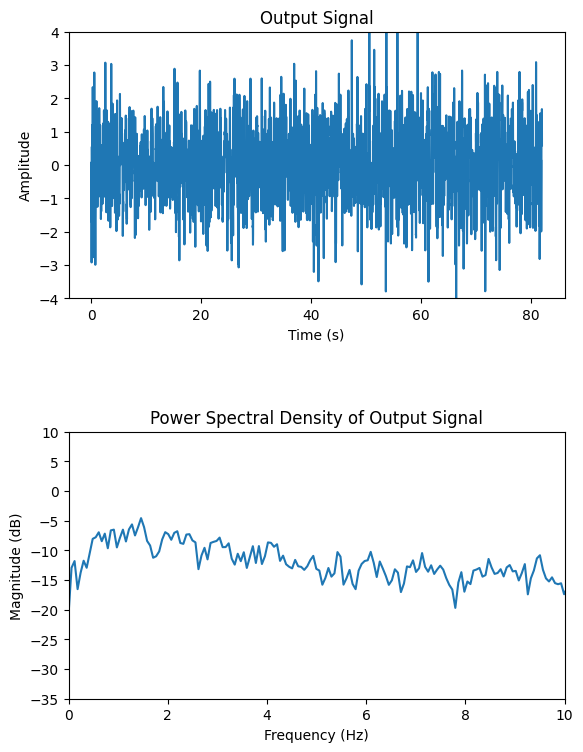

In [ ]:
#Plot generated signal
length_output = np.size(output)
t_output = np.linspace(0, length_output/fs, length_output)
#Generated signal
plt.subplot(2,1,1)
plt.plot(t_output, output)
#plt.xlim([0,10]) #Set time values to zoom on a part of the input signal (seconds)
plt.ylim([-4,4]) #Adjust amplitude values for better viewing
plt.title('Output Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

#Plot PSD plot of output signal
plt.subplot(2,1,2)
plt.plot(f_output, 10*np.log10(pxx_output))
plt.xlim([0,10]) #Frequency values (Hz) can be adjusted for better viewing
plt.ylim([-35,10]) #Magnitude values (dB) can be adjusted for better viewing
plt.title('Power Spectral Density of Output Signal')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=0.5)

## Save the Generated Motion Artifact Data

The simulated motion artifact signal can be saved in one of two ways.

**Option 1: Save simulated motion artifact data directly to computer**

In the cell below, change "*generated_signal*" to what you would like the file to be called. The file will be saved in *.csv* format.

To download the simulated motion artifact data, run the cell below.

In [ ]:
df = pd.DataFrame(output)
df.to_csv("generated_signal.csv")
files.download('generated_signal.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Option 2: Save simulated motion artifact data to a file on Google Drive**

Change the filename to what you would like to save the file as. You will also need to change the file path to adjust where the file is saved within your Google Drive. If you have not yet done so, ensure your Google Drive is mounted onto this notebook as seen in the first cell of "Option 2" of "Uploading Sample Motion Artifact Data". The file will be saved in *.csv* format.

In the cell below, change 'NEW_FILE_NAME' and 'NEW_FILE_PATH' accordingly.

In [ ]:
df = pd.DataFrame(output)
filename = "NEW_FILE_NAME"
df.to_csv("/content/drive/My Drive/NEW_FILE_PATH/{}.csv".format(filename))